# Modular Neural Network for CIFAR 10


In the below lines of code, an attempt to implement MNN for CIFAR 10 dataset has been made. 

* Contents of dataset :  
> 60000 32x32 colour images in 10 classes, with 6000 images per class
> There are 50000 training images and 10000 test images

* The model that has been implemented based on the [research paper](https://drive.google.com/file/d/1eLd8RO6nVFDBdYpXCGVngzabiVaIphKM/view?usp=sharing) :

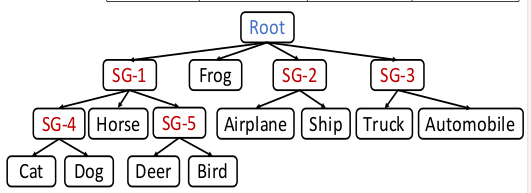



In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install h5py==2.10.0
import h5py
h5py.__version__

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Loading the dataset and obtaining training and test sets

In [ ]:
# Importing libraries initially required
import matplotlib.pyplot as plots
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers
from tensorflow.keras.datasets import cifar10
import numpy as np

# loading cifar 10 dataset for training and testing.
#x--> Images, y--> labels
(img_train, label_train), (img_test, label_test) = cifar10.load_data()





# setting class names
c10_classes=['plane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#----------0:g2,-----1:g3,-----2:g1,5---3:g1,4-----4:g1,5-----5:g1,4----6:g0---7:g1-----8:g2------9:g3

#normalizing the data
img_train=img_train/255.0
img_train.shape
img_test=img_test/255.0
img_test.shape

#reshaping 2D shape of labels to 1D
label_test = label_test.reshape(-1,)
label_train = label_train.reshape(-1,)
label_train = to_categorical(label_train, 10)
label_test = to_categorical(label_test, 10)



Root (level 0)- VGG block of size 1
Supergroups at level 1 - VGG block of size 2
Supergroups at level 2 - VGG block of size 3


# 2. Defining wavelet pooling layer

In [ ]:
import tensorflow.keras.backend
from tensorflow.keras.layers import Layer

def normalize_data_reference(data):
    if data is None:
        data = tensorflow.keras.backend.image_data_format()
    data_reference = data.lower()
    if data_reference not in {'channels_first', 'channels_last'}:
        raise ValueError('Please give an input that is part of  '
                         '"channels_first" or "channels_last". Cannot process ' +
                         str(data)+'data')
    return data_reference


class dwt_layer(Layer):
    def __init__(self, data_reference=None,**kwargs):
        super(dwt_layer, self).__init__(**kwargs)
        self.data_reference = normalize_data_reference(data_reference)

    def build(self, input_shape):
        super(dwt_layer, self).build(input_shape) 

    def call(self, n):
        return wavelet(n, self.data_reference)

    def compute_output_shape(self, input_shape):
        if self.data_reference == 'channels_first':
            return (input_shape[0], input_shape[1]*4, input_shape[2]//2, input_shape[3]//2)
        elif self.data_reference == 'channels_last':
            return (input_shape[0], input_shape[1]//2, input_shape[2]//2, input_shape[3]*4)


def wavelet(n, data_reference='channels_last'):
    if data_reference == 'channels_last':
        n1 = n[:, 0::2, 0::2, :] 
        n2 = n[:, 1::2, 0::2, :] 
        n3 = n[:, 0::2, 1::2, :] 
        n4 = n[:, 1::2, 1::2, :] 

    elif data_reference == 'channels_first':
        n1 = n[:, :, 0::2, 0::2] 
        n2 = n[:, :, 1::2, 0::2] 
        n3 = n[:, :, 0::2, 1::2] 
        n4 = n[:, :, 1::2, 1::2]      

    LL = n1 + n2 + n3 + n4
    LH = -n1 - n3 + n2 + n4
    HL = -n1 + n3 - n2 + n4
    HH = n1 - n3 - n2 + n4

    if data_reference == 'channels_last':
        return tensorflow.keras.backend.concatenate([LL,LH,HL,HH],axis=-1)
    elif data_reference == 'channels_first':
        return tensorflow.keras.backend.concatenate([LL,LH,HL,HH],axis=1)



# 3. Loading weights of root node and supergroups

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD



file_list=[]
path="/content/drive/MyDrive/01_Colab_MNN/sgd/"

root = tf.keras.models.load_model(str(path+'root.h5'), custom_objects={'dwt_layer':  dwt_layer})
loss,va1= root.evaluate(img_test,label_test,8)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
10000/10000 [==============================] - 22s 2ms/sample - loss: 1.0150 - acc: 0.6365


In [ ]:
import os

root_path =path="/content/drive/MyDrive/01_Colab_MNN/sgd/root.h5"

path="/content/drive/MyDrive/01_Colab_MNN/sgd/"

stats = os.stat(str(path+'root.h5'))
print('Model size of \tROOT file     : ', (stats.st_size/10**6), 'Mb')
MS1=(stats.st_size/10**6)
MS_list=[]
for i in range(6):
  file_name='sg'+str(i)+'.h5'
  file_path=str(path+file_name)
  file_list.append(str(file_path))
  stats = os.stat(file_path)
  print('Model size of ',' supergroup ',str(i),': ', (stats.st_size/10**6), 'Mb')
  MS_list.append((stats.st_size/10**6))


Model size of 	ROOT file     :  50.609168 Mb
Model size of   supergroup  0 :  34.595416 Mb
Model size of   supergroup  1 :  714.344296 Mb
Model size of   supergroup  2 :  156.739568 Mb
Model size of   supergroup  3 :  226.433392 Mb
Model size of   supergroup  4 :  275.491648 Mb
Model size of   supergroup  5 :  213.182784 Mb


In [ ]:



import numpy as np
avg = np.mean(img_train,axis=(0,1,2,3))
SD = np.std(img_train,axis=(0,1,2,3))
img_train = (img_train-avg)/(SD+1e-7)
img_test = (img_test-avg)/(SD+1e-7)



va_list=[]
path="/content/drive/MyDrive/01_Colab_MNN/sgd/"
file_list=[]
for i in range(6):
  file_name='sg'+str(i)+'.h5'
  file_path=str(path+file_name)
  file = tf.keras.models.load_model(file_path, custom_objects={'dwt_layer':  dwt_layer})
  loss,va= file.evaluate(img_test,label_test,8)
  va_list.append(va)
  file_list.append(file)
  print('\n',str(file_name),' ',va)
  


10000/10000 [==============================] - 46s 5ms/sample - loss: 0.8699 - acc: 0.7608

 sg0.h5   0.7608
10000/10000 [==============================] - 63s 6ms/sample - loss: 0.7271 - acc: 0.7506

 sg1.h5   0.7506
10000/10000 [==============================] - 71s 7ms/sample - loss: 0.7449 - acc: 0.7398

 sg2.h5   0.7398
10000/10000 [==============================] - 66s 7ms/sample - loss: 0.8124 - acc: 0.7203

 sg3.h5   0.7203
10000/10000 [==============================] - 113s 11ms/sample - loss: 0.5790 - acc: 0.8061

 sg4.h5   0.8061
10000/10000 [==============================] - 81s 8ms/sample - loss: 0.6339 - acc: 0.7873

 sg5.h5   0.7873


In [ ]:
def delta_AD(va1,va2,MS1,MS2):
    AD=((va2-va1)/(MS2-MS1))
    return AD

del_AD=[]
for i in range(6):
  MS2=(MS_list[i])
  va2=(va_list[i])
  res=delta_AD(va1,va2,MS1,MS2)
  del_AD.append(res)
  print(res)


0.0070157656074963035
0.00016359214609683805
0.0007385882116431576
0.00039989468853741017
0.0006558050073981177
0.0007681938352680818


# 3. Testing trained supergroups 



In [ ]:
'''
----------------0------------1---------2------3-----4-----5-------6------7------8-------9-----
c10_classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#----------0:g2,-----1:g3,-----2:g1,5---3:g1,4-----4:g1,5-----5:g1,4----6:g0---7:g1-----8:g2------9:g3
#frog--> 
#airplane,ship :              0,8 --- > g2
#automobile,truck:            1,9 ---> g3
#bird,cat,deer,dog,horse:  2,3,4,5,7
#cat,dog --> sg4 (3,5)
#bird,deer --> sg5 (2,4)
###################################################################################################################################################
'''
import gc
threshold = 0.1



import numpy as np
avg = np.mean(img_train,axis=(0,1,2,3))
SD = np.std(img_train,axis=(0,1,2,3))
img_train = (img_train-avg)/(SD+1e-7)
img_test = (img_test-avg)/(SD+1e-7)
error=[]

y=len(label_test)
for x in range(0,6):
        print('Super group ',x,': AD = ',del_AD[x])
        sg=('sg'+str(x))
        sg = tf.keras.models.load_model(str(path+'sg'+str(x)+'.h5'), custom_objects={'dwt_layer':  dwt_layer})
        MS2=MS_list[x]
        err,va2= sg.evaluate(img_test,label_test,8)
        error.append(err)
        del_AD[x]=delta_AD(va1,va2,MS1,MS2)
        va2=va_list[x]
        print('Super group ',x,': AD = ',del_AD[x])


Super group  0 : AD =  0.0070157656074963035
10000/10000 [==============================] - 51s 5ms/sample - loss: 0.8699 - acc: 0.7608
Super group  0 : AD =  0.0070157656074963035
Super group  1 : AD =  0.00016359214609683805
10000/10000 [==============================] - 68s 7ms/sample - loss: 0.7271 - acc: 0.7506
Super group  1 : AD =  0.00016359214609683805
Super group  2 : AD =  0.0007385882116431576
10000/10000 [==============================] - 70s 7ms/sample - loss: 0.7449 - acc: 0.7398
Super group  2 : AD =  0.0007385882116431576
Super group  3 : AD =  0.00039989468853741017
10000/10000 [==============================] - 70s 7ms/sample - loss: 0.8124 - acc: 0.7203
Super group  3 : AD =  0.00039989468853741017
Super group  4 : AD =  0.0006558050073981177
10000/10000 [==============================] - 112s 11ms/sample - loss: 0.5790 - acc: 0.8061
Super group  4 : AD =  0.0006558050073981177
Super group  5 : AD =  0.0007681938352680818
10000/10000 [==============================]

In [ ]:
for i in range(0,6):
        if (del_AD[x]<threshold) and (error[x]<1):
              print("threshold is ",threshold,". With an a change in accuracy density of ",del_AD[x]," and an error rate of ",error[x]," the DNN subgroup is optimum")
        else:
              print("threshold is ",threshold,". With an a change in accuracy density of ",del_AD[x]," and an error rate of ",error[x]," the DNN subgroup is  not optimum")

 

threshold is  0.1 . With an a change in accuracy density of  0.0007681938352680818  and an error rate of  0.6338872748196125  the DNN subgroup is optimum
threshold is  0.1 . With an a change in accuracy density of  0.0007681938352680818  and an error rate of  0.6338872748196125  the DNN subgroup is optimum
threshold is  0.1 . With an a change in accuracy density of  0.0007681938352680818  and an error rate of  0.6338872748196125  the DNN subgroup is optimum
threshold is  0.1 . With an a change in accuracy density of  0.0007681938352680818  and an error rate of  0.6338872748196125  the DNN subgroup is optimum
threshold is  0.1 . With an a change in accuracy density of  0.0007681938352680818  and an error rate of  0.6338872748196125  the DNN subgroup is optimum
threshold is  0.1 . With an a change in accuracy density of  0.0007681938352680818  and an error rate of  0.6338872748196125  the DNN subgroup is optimum


# 4. Checking to ensure improvement in accuracy

In [ ]:
for i in range(0,6):
  if va_list[i]!=0:
     print("Accuracy of supergroup"+str(x)+" 0 :",va_list[i]*100)

Accuracy of supergroup5 0 : 76.08000040054321
Accuracy of supergroup5 0 : 75.05999803543091
Accuracy of supergroup5 0 : 73.9799976348877
Accuracy of supergroup5 0 : 72.0300018787384
Accuracy of supergroup5 0 : 80.61000108718872
Accuracy of supergroup5 0 : 78.72999906539917


In [ ]:
print("Accuracy of root node :",va1*100)
for i in range(6):
    if va_list[i]>va1:
        print("Supergroup ",i," has improved. From ",va1*100,"% to ",va_list[i]*100,"%")

Accuracy of root node : 63.65000009536743
Supergroup  0  has improved. From  63.65000009536743 % to  76.08000040054321 %
Supergroup  1  has improved. From  63.65000009536743 % to  75.05999803543091 %
Supergroup  2  has improved. From  63.65000009536743 % to  73.9799976348877 %
Supergroup  3  has improved. From  63.65000009536743 % to  72.0300018787384 %
Supergroup  4  has improved. From  63.65000009536743 % to  80.61000108718872 %
Supergroup  5  has improved. From  63.65000009536743 % to  78.72999906539917 %


In [ ]:
gc.collect()

6553

# 5. Checking with sample images that from the CIFAR-10 dataset

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [ ]:
gc.collect()

In [ ]:
path="/content/drive/MyDrive/01_Colab_MNN/sgd/"

sg0 = tf.keras.models.load_model(str(path+'sg0.h5'), custom_objects={'dwt_layer':  dwt_layer})
sg1 = tf.keras.models.load_model(str(path+'sg1.h5'), custom_objects={'dwt_layer':  dwt_layer})
sg2 = tf.keras.models.load_model(str(path+'sg2.h5'), custom_objects={'dwt_layer':  dwt_layer})
sg3 = tf.keras.models.load_model(str(path+'sg3.h5'), custom_objects={'dwt_layer':  dwt_layer})
sg4 = tf.keras.models.load_model(str(path+'sg4.h5'), custom_objects={'dwt_layer':  dwt_layer})
sg5 = tf.keras.models.load_model(str(path+'sg5.h5'), custom_objects={'dwt_layer':  dwt_layer})


In [ ]:
'''
----------------0------------1---------2------3-----4-----5-------6------7------8-------9-----
c10_classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#----------0:g2,-----1:g3,-----2:g1,5---3:g1,4-----4:g1,5-----5:g1,4----6:g0---7:g1-----8:g2------9:g3
#frog--> 
#airplane,ship :              0,8 --- > g2
#automobile,truck:            1,9 ---> g3
#bird,cat,deer,dog,horse:  2,3,4,5,7
#cat,dog --> sg4 (3,5)
#bird,deer --> sg5 (2,4)
###################################################################################################################################################
'''
if label_test.all() in [6]: predictions = sg0.predict(img_test)
if label_test.all() in [2,3,4,5,7]: predictions = sg1.predict(img_test)
if label_test.all() in [0,8]: predictions = sg2.predict(img_test)
if label_test.all() in [1,9]: predictions = sg3.predict(img_test)
if label_test.all() in [3,5]: predictions = sg3.predict(img_test)

if label_test.all() in [2,4]: predictions = sg5.predict(img_test)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

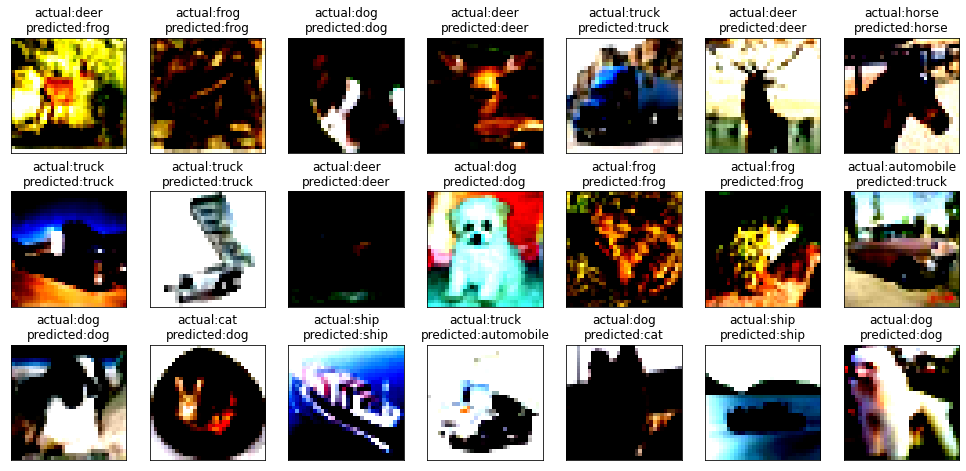

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False,
    sharey=True, figsize=(17, 8))
index = 500
for i in range(3):
    for j in range(7):
            axes[i,j].set_title('actual:' + c10_classes[(int(np.argmax(label_test[index])))] + '\n' + 'predicted:' + c10_classes[(int(np.argmax(predictions[index])))])
            axes[i,j].imshow(img_test[index], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            index += 1
plt.show()

# Conclusion :
* All supergroups  have shown improvement in accuracy and it has been cross check